In [1]:
import simpy
import numpy as np
import statistics
import matplotlib.pyplot as plt

In [2]:
np.random.seed(12345)

In [3]:
"""
Used sources: 
- https://stackoverflow.com/questions/73384766/simple-m-m-1-queuing-simulation-with-simpy-departure-placement-issue
- https://simpy.readthedocs.io/en/latest/examples/bank_renege.html
- https://www.youtube.com/watch?v=eSNfC-HOl44
"""

'\nUsed sources: \n- https://stackoverflow.com/questions/73384766/simple-m-m-1-queuing-simulation-with-simpy-departure-placement-issue\n- https://simpy.readthedocs.io/en/latest/examples/bank_renege.html\n- https://www.youtube.com/watch?v=eSNfC-HOl44\n'

In [65]:
def generate_inter_arrival_time(labda):
    return np.random.exponential(labda)

def generate_service_time(mu):
    return np.random.exponential(mu)

observation_times = []
queue_lengths = []
server_lengths = []
def observe(env, servers, measurement_time_interval):
    """
    Takes the environment and servers as arguments in order to refer to the right server

    Uses two lists in order to plot meaningful results. 
    One is used to append the current timestep
    The other is used to state the length of the queue
    """
    while True:
        # current time
        observation_times.append(env.now)
        # current queue length
        queue_lengths.append(len(servers.queue))
        # current server processing length (either 0 or 1)
        server_lengths.append((len(servers.users)))

        # make an observation every 1 timestep
        yield env.timeout(measurement_time_interval)

def generator(env, servers, mean_arrivals, mean_served):
    """
    In case of a cafe or shop, this simulates the entire environment i.e. the shop.
    """
    # set i in order to be able to identify customers
    i = 0 

    while True:
        i+=1
        service_time = generate_service_time(mean_arrivals)
        yield env.timeout(generate_inter_arrival_time(mean_served))
        env.process(customer(env, i, service_time, servers))

def customer(env, customer, service_time, servers):
    """
    Processes a customer

    First argument is the environment that it will be operating in
    second argument is the server, so that the customer generator knows what are
    the servers that it have access to
    """
    # with priority, choses the lowest service time
    with servers.request(priority=service_time) as request:
        # Customer arrives
        arrival_time = env.now
        # customer gets serviced
        print(f"At time: {env.now: .2f} | customer {customer} joins queue with service time {service_time:.2f}")
        yield request # request and wait until server is free
        # customer has been serviced 
        print(f"At time: {env.now: .2f} | customer {customer} is being served with service time {service_time:.2f}")
        service_times.append(service_time)
        yield env.timeout(service_time) # service takes time labda
        # departs
        print(f"At time: {env.now: .2f} | customer {customer} departs with service time {service_time:.2f}")
        departure_time = env.now
        waiting_times.append(departure_time - arrival_time)
# intuition for yield: pause function until this event happens

In [66]:
"""
Run a simulation
"""
# to observe over all runs
average_waiting_times = []
average_service_times = []
average_total_times = []
average_q_lengths = []
average_total_in_systems = []

# set parameters
labda = 4 # average number of arrivals per time period
mu = 6 # average number of customers served per time period
mean_arrivals = 1/labda # mean inter-arrival time
mean_served = 1/mu # time to serve one customer

number_of_simulations = 50
simulation_time = 100
measurement_time_interval = 2
dimension = int(simulation_time/measurement_time_interval)
q_lengths_matrix = np.empty((0, dimension))
for i in range(number_of_simulations):  
    # to observe in a sigle run
    observation_times = []
    queue_lengths = []
    server_lengths = []
    waiting_times = []
    service_times = []

    # initialize environment
    env = simpy.Environment()
    servers = simpy.PriorityResource(env, capacity=1)
    env.process(generator(env, servers, mean_arrivals, mean_served))
    env.process(observe(env, servers, measurement_time_interval))
    env.run(until=simulation_time)

    # keep track of statistics
    # average_waiting_time = statistics.mean(waiting_times)
    # average_service_time = statistics.mean(service_times)
    # average_waiting_times.append(average_waiting_time)
    # average_service_times.append(average_service_time)
    # average_total_times.append(average_waiting_time + average_service_time)
    # average_q_lengths.append(statistics.mean(queue_lengths))
    # total_in_system = np.add(queue_lengths, server_lengths)
    # average_total_in_systems.append(statistics.mean(total_in_system))     # average number of customers in the system (waiting and being served)
    print(queue_lengths)
    q_lengths_matrix = np.vstack([q_lengths_matrix, queue_lengths])
    print(q_lengths_matrix)

At time:  0.66 | customer 1 joins queue with service time 0.01
At time:  0.66 | customer 1 is being served with service time 0.01
At time:  0.67 | customer 1 departs with service time 0.01
At time:  0.69 | customer 2 joins queue with service time 0.17
At time:  0.69 | customer 2 is being served with service time 0.17
At time:  0.86 | customer 2 departs with service time 0.17
At time:  1.07 | customer 3 joins queue with service time 0.09
At time:  1.07 | customer 3 is being served with service time 0.09
At time:  1.16 | customer 3 departs with service time 0.09
At time:  1.21 | customer 4 joins queue with service time 0.13
At time:  1.21 | customer 4 is being served with service time 0.13
At time:  1.34 | customer 4 departs with service time 0.13
At time:  1.69 | customer 5 joins queue with service time 0.27
At time:  1.69 | customer 5 is being served with service time 0.27
At time:  1.83 | customer 6 joins queue with service time 0.75
At time:  1.96 | customer 5 departs with service ti

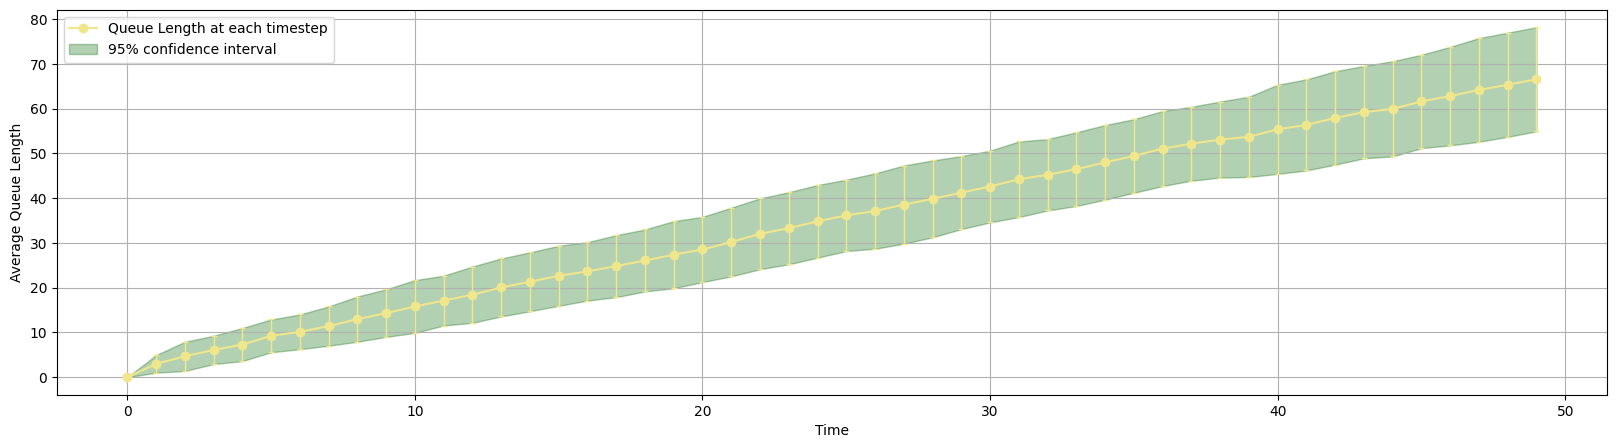

In [67]:
"""
Print and plot results
"""

matrix = q_lengths_matrix

plt.figure(figsize=(20, 5))
column_means = np.mean(matrix, axis=0)
column_std_devs = np.std(matrix, axis=0)

x_axis = range(dimension)
plt.plot(x_axis, column_means, marker="o", color="khaki", label="Queue Length at each timestep")
plt.fill_between(x_axis, column_means - column_std_devs, column_means + column_std_devs, 
                 color="darkgreen", alpha=0.3, label="95% confidence interval")
plt.errorbar(x_axis, column_means, yerr=column_std_devs, fmt="s", color="khaki", capsize=2, markersize=4, elinewidth=1)
plt.xlabel("Time")
plt.ylabel("Average Queue Length")
plt.legend()
plt.grid()
plt.show()



# print(f"Average Waiting Time Is : {average_waiting_time: .4f}" )
# print(f"Average Service Time Is : {average_service_time: .4f}" )
# print(f"Average Total time is: {average_total_time}")
# print(f"average queue length is: {average_q_length}")
# print(f"average number of customers in the system: {average_total_in_system: .2f}")

# plt.figure()
# plt.plot(range(number_of_simulations), average_waiting_times, label = "Average waiting times")
# plt.plot(range(number_of_simulations), average_service_times, label = "Average service times")
# plt.plot(range(number_of_simulations), average_total_times, label = "Average total time in system")
# plt.legend()

# plt.figure()
# plt.plot(range(number_of_simulations), average_total_in_systems)



# plt.figure()
# plt.hist(waiting_times)
# plt.xlabel("waiting time in min")
# plt.ylabel("number of customers")
# plt.axvline(average_waiting_time, color="red")

# plt.figure()
# plt.step(observation_times, queue_lengths, where="post")
# plt.xlabel("time")
# plt.ylabel("Length")
# plt.axhline(average_q_length, color="red") 